In [1]:
# This code presents an implementation of Zhmoginov et al.'s paper
# titled 'Inverting Facial Embeddings'

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from mtcnn import mtcnn
import cv2

In [2]:
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 160

In [3]:
a = np.load('train-data3.npz')
pictures, embeddings, names = a.f.arr_0, a.f.arr_1, a.f.arr_2

This is a picture of Roh_Moo-hyun


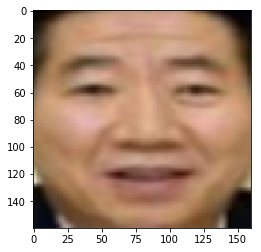

In [6]:
# Sanity check
ind = 2
pyplot.imshow(asarray(pictures[ind]))
print('This is a picture of', names[ind])

In [5]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Activation

In [6]:
model_file = 'model/facenet_keras.h5'
FRmodel = tf.keras.models.load_model(model_file)
# summarize input and output shape
print(FRmodel.inputs)
print(FRmodel.outputs)
# FRmodel.load_weights("model/facenet_keras_weights.h5")

[<tf.Tensor 'input_1:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm/add_1:0' shape=(?, 128) dtype=float32>]


In [7]:
# mark loaded layers as not trainable
# for layer in FRmodel.layers:
#   layer.trainable = False

In [8]:
# FRmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
def loss(y, yhat):
    return np.maximum(0, np.linalg.norm(y-yhat)-11)

def get_decoding_model2(nL=64):
    # define model
    model = Sequential()
    # define input shape, output enough activations for for 32 5x5 maps
    model.add(Dense(32 * 5 * 5, input_dim=128))
    model.add(Activation('relu'))
    model.add(Dense(32 * 5 * 5))
    model.add(Activation('relu'))
    
    # reshape vector of activations into 128 feature maps with 5x5
    model.add(Reshape((5, 5, 32)))
    
    # double input to 32 10x10 feature map
    model.add(Conv2DTranspose(nL, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(nL, (5,5), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # double input to 64 20x20 feature map
    model.add(Conv2DTranspose(nL, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(nL, (5,5), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # double input to 128 40x40 feature map
    model.add(Conv2DTranspose(nL, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(nL, (5,5), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # double input to 8 80x80 feature map
    model.add(Conv2DTranspose(nL, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(nL, (5,5), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    

#     double input to 1 160x160x3 feature map
    model.add(Conv2DTranspose(3, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(3, (5,5), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
#     model.add(Activation('relu'))
    
    # Dense layer of same size leading to output
#     model.add(Reshape((160*160*3,)))
#     model.add(Dense(160 * 160 * 3))

    # Apply sigmoid
    model.add(Activation('sigmoid'))
    
    return model

def get_decoding_model(nL=64):
    # define model
    model = Sequential()
    # define input shape, output enough activations for for 16 10x10 maps
    model.add(Dense(64 * 5 * 5, input_dim=128))
    model.add(Activation('relu'))
    # define input shape, output enough activations for for 16 10x10 maps
#     model.add(Dense(16 * 5 * 5))
#     model.add(Activation('relu'))
    
    # reshape vector of activations into 128 feature maps with 5x5
    model.add(Reshape((5, 5, 64)))
    
    # double input to 32 10x10 feature map
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # double input to 64 20x20 feature map
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))


    # double input to 128 40x40 feature map
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # double input to 8 80x80 feature map
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2DTranspose(64, (4,4), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    

#     double input to 1 160x160x3 feature map
    model.add(Conv2DTranspose(32, (4,4), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2DTranspose(3, (4,4), strides=(1,1), padding='same'))
    
    # Dense layer of same size leading to output
#     model.add(Reshape((160*160*3,)))
#     model.add(Dense(160 * 160 * 3))

    # Apply sigmoid
    model.add(Activation('sigmoid'))
#     model.add(Reshape((160,160,3)))

    # summarize model
    # model.summary()
    # print("input:",model.inputs)
    # model.outputs
    return model

def shitty_model():
    # define model
    model = Sequential()
    # define input shape, output enough activations for for 128 5x5 maps
    model.add(Dense(128 * 5 * 5, input_dim=128))
    # reshape vector of activations into 128 feature maps with 5x5
    model.add(Reshape((5, 5, 128)))
    # double inputto 64 10x10 feature map
    model.add(Conv2DTranspose(64, (3,3), strides=(2,2), padding='same'))
    model.add(Conv2DTranspose(64, (3,3), strides=(1,1), padding='same'))

    model.add(BatchNormalization())

    # double input to 32 20x20 feature map
    model.add(Conv2DTranspose(32, (3,3), strides=(2,2), padding='same'))
    model.add(Conv2DTranspose(32, (3,3), strides=(1,1), padding='same'))

    model.add(BatchNormalization())

    # double input to 16 40x40 feature map
    model.add(Conv2DTranspose(16, (3,3), strides=(2,2), padding='same'))
    model.add(Conv2DTranspose(16, (3,3), strides=(1,1), padding='same'))

    model.add(BatchNormalization())

    # double input to 4 80x80 feature map
    model.add(Conv2DTranspose(8, (3,3), strides=(2,2), padding='same'))
    model.add(Conv2DTranspose(8, (3,3), strides=(1,1), padding='same'))

    model.add(BatchNormalization())

    # double input to 1 160x160x3 feature map
    model.add(Conv2DTranspose(3, (3,3), strides=(2,2), padding='same'))

    # Apply sigmoid
    model.add(Activation('sigmoid'))

    # summarize model
    # model.summary()
    # print("input:",model.inputs)
    # model.outputs
    return model


def dcgan():
    kernel_size = 5
    starting_filters = 64
    
    model = Sequential()
#     model.add(
#         Dense(starting_filters * (self.img_size[0] // (2 ** self.upsample_layers))  *  (self.img_size[1] // (2 ** self.upsample_layers)),
#               activation="relu", input_shape=noise_shape))
#     model.add(Reshape(((self.img_size[0] // (2 ** self.upsample_layers)),
#                        (self.img_size[1] // (2 ** self.upsample_layers)),
#                        self.starting_filters)))
    model.add(Dense(starting_filters * 5 * 5, input_dim=128))
    # reshape vector of activations into 128 feature maps with 5x5
    model.add(Reshape((5, 5, starting_filters)))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 6x8 -> 12x16
    model.add(Conv2D(128, kernel_size=kernel_size, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 12x16 -> 24x32
    model.add(Conv2D(64, kernel_size=kernel_size, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 24x32 -> 48x64
    model.add(Conv2D(64, kernel_size=kernel_size, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 48x64 -> 96x128
    model.add(Conv2D(64, kernel_size=kernel_size, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 96x128 -> 192x256
    model.add(Conv2D(64, kernel_size=kernel_size, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(32, kernel_size=kernel_size, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(3, kernel_size=kernel_size, padding="same"))
    model.add(Activation("sigmoid")) # instead of tanh
    return model




# Pretrain decoding model on real image so initial training starts better for entire model
def pretrain_decoding_model(decoding_model):
    # instead of loss='mean_squared_error'
    decoding_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    decoding_model.fit(embeddings, (pictures/256.0)*2 - 1,
                     epochs=2,
                     batch_size=128)

def save_decoding_model(decoding_model):
    decoding_model.save("decoding_model.h5")

def combineModels(model1, model2):
    return Sequential([
        model1,
        model2
    ])

Using TensorFlow backend.


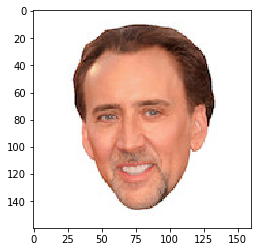

In [10]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# load guiding image
guiding_img = load_img('guiding.jpg', target_size=(160,160,3))
guiding_img = img_to_array(guiding_img) / 255.0
pyplot.imshow(guiding_img)

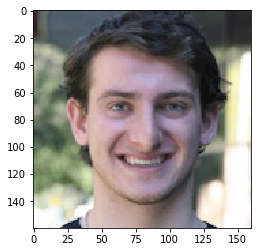

In [11]:
# 12 is also good
desired_img = load_img('ethan.jpg', target_size=(160,160,3))
desired_img = img_to_array(desired_img) / 255.0
# pyplot.imshow(desired_img)
# desired_img = pictures[0] / 256.0
desired_img = np.expand_dims(desired_img, axis=0)
desired_emb = FRmodel.predict(desired_img)
pyplot.imshow(desired_img[0])

In [78]:
def getGuideLoss():
    #'Block35_1_Concatenate' early
    #'Block8_4_Activation' late
    #'Block17_10_Activation'
    #'Block35_3_Conv2d_1x1' center-beginning
    layer_name = 'Block8_4_Activation'
    intermediate_layer_model = Model(inputs=FRmodel.input,
                                     outputs=FRmodel.get_layer(layer_name).output)
    intermediate_output = intermediate_layer_model.predict(np.expand_dims(guiding_img, axis=0))
    #guide = K.sum(K.square(FRmodel.input[0] - guiding_img))

    guide = K.sqrt(K.sum(K.square(FRmodel.get_layer(layer_name).output - intermediate_output)))
    return guide

In [87]:
def createIterator(reg_weight=30):
    # loss = K.categorical_crossentropy(desired_emb, FRmodel.output)
    # have to add negative because want this to go down as accuracy increases
    loss = K.dot(K.constant(-desired_emb), K.transpose(FRmodel.output))

    # s_x = 
    x_diff = K.sum(K.square(FRmodel.input[0,1:,:,:] - FRmodel.input[0,:-1,:,:]))
    y_diff = K.sum(K.square(FRmodel.input[0,:,1:,:] - FRmodel.input[0,:,:-1,:]))
    reg = K.sqrt(x_diff+y_diff)
    
    guide = getGuideLoss()
    
    total = K.sqrt(K.sum(K.square(guiding_img - FRmodel.input)))

    loss = 2*loss + reg_weight*reg + 3*guide

    # loss = K.mean(desired_img)
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    # layer_dict = dict([(layer.name, layer) for layer in FRmodel.layers])

    # build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    # layer_name = 'Block8_2_Activation'
    # layer_output = layer_dict[layer_name].output
    # loss = K.mean(layer_output[:, :, :, filter_index])

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, FRmodel.input)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads)))+ 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([FRmodel.input], [loss, grads])

    return iterate


# run gradient ascent for some number of steps
def update_img(times, alpha, iterate, input_img_data):
    for i in range(times):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data -= grads_value * alpha
        #input_img_data = np.clip(input_img_data, 0, 1)
        if i % 10 == 0:
            print("running iteration ", i, 'loss: ', loss_value, ' norm:', np.linalg.norm(grads_value))

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
#     x *= 255
#     x = x.transpose((1, 2, 0))
#     x = np.clip(x, 0, 255).astype('uint8')
    return x

In [88]:
# FRmodel.summary()

In [89]:
iterator30 = createIterator(reg_weight=60)
iterator20 = createIterator(reg_weight=30)
iterator10 = createIterator(reg_weight=10)


allimages = []
for i in range(6):
    print('--> trial', i)
    input_img_data = np.random.random((1, 160, 160, 3))
    update_img(50, 0.1, iterator30, input_img_data)
    update_img(50, 0.05, iterator30, input_img_data)
    update_img(50, 0.01, iterator20, input_img_data)
#     update_img(50, 0.005, iterator10, input_img_data)
    allimages.append(input_img_data+0.0)

--> trial 0
running iteration  0 loss:  [[9742.706]]  norm: 277.12247
running iteration  10 loss:  [[2246.0261]]  norm: 277.1236
running iteration  20 loss:  [[2088.2822]]  norm: 277.1236
running iteration  30 loss:  [[1968.3541]]  norm: 277.12366
running iteration  40 loss:  [[1917.7448]]  norm: 277.12317
running iteration  0 loss:  [[1884.6106]]  norm: 277.12335
running iteration  10 loss:  [[901.7069]]  norm: 277.12305
running iteration  20 loss:  [[879.65454]]  norm: 277.1233
running iteration  30 loss:  [[856.9282]]  norm: 277.123
running iteration  40 loss:  [[973.78455]]  norm: 277.12347
running iteration  0 loss:  [[345.03442]]  norm: 277.11978
running iteration  10 loss:  [[-12.397507]]  norm: 277.11737
running iteration  20 loss:  [[-22.149979]]  norm: 277.12003
running iteration  30 loss:  [[-31.103043]]  norm: 277.12167
running iteration  40 loss:  [[-51.332443]]  norm: 277.1175
--> trial 1
running iteration  0 loss:  [[9714.405]]  norm: 277.12244
running iteration  10 loss

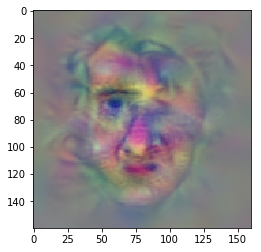

In [90]:
pyplot.imshow(allimages[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


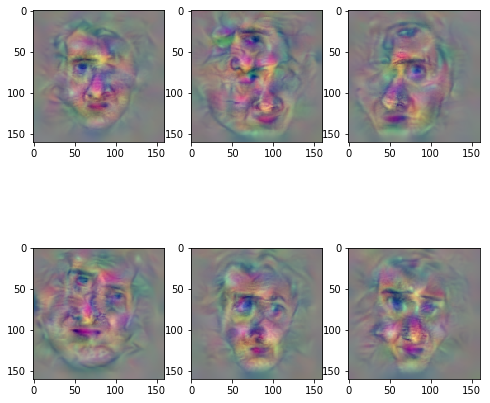

In [91]:
# img = allimages[2][0]
# img = deprocess_image(img)
# pyplot.imshow(np.clip(img, 0, 1))
# pyplot.imshow(deprocess_image(img+0.0))

# fig=pyplot.figure(figsize=(160, 160))
# columns = 3
# rows = 2
# for i in range(1, 7):
#     img = allimages[i-1]
#     fig.add_subplot(rows, columns, i)
#     pyplot.imshow(img)
# pyplot.show()

# w=40
# h=40
fig=pyplot.figure(figsize=(8, 8))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    img = allimages[i-1][0] #np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    pyplot.imshow(img)
pyplot.show()


In [243]:
decoding_model = get_decoding_model()

In [95]:
emb_test = FRmodel.predict(pictures[0:1])

17.807665

In [244]:
decoding_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 1600)              206400    
_________________________________________________________________
activation_95 (Activation)   (None, 1600)              0         
_________________________________________________________________
reshape_15 (Reshape)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_transpose_46 (Conv2DT (None, 10, 10, 64)        65600     
_________________________________________________________________
batch_normalization_75 (Batc (None, 10, 10, 64)        256       
_________________________________________________________________
activation_96 (Activation)   (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_transpose_47 (Conv2DT (None, 20, 20, 64)      

In [245]:
#decoding_model = tf.keras.models.load_model('decoding_model.h5')#get_decoding_model()
decoding_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
# Create our full model
# my_input = Input(shape=(128,))

In [65]:
# import keras.backend as K

In [12]:
def l2_dist(y_true, y_pred):
    #mean squared loss
    return tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)), axis=-1)
#     return K.dot(K.transpose(y_pred), y_true,)
def dot_dist(y_true, y_pred):
    return tf.reduce_sum( tf.multiply( y_true, y_pred ), 1, keep_dims=True )

In [191]:
guiding_image = tf.divide(tf.expand_dims(tf.constant(pictures[40], dtype=tf.float32), 0), 256.0)

In [202]:
guiding_image

<tf.Tensor 'truediv_1:0' shape=(1, 160, 160, 3) dtype=float32>

In [230]:
def total_variation(pic):
    pic_x1 = tf.slice(pic, (0, 0,0,0),(-1,159,-1,-1))
    pic_x2 = tf.slice(pic, (0, 1,0,0),(-1,159,-1,-1))
    pic_y1 = tf.slice(pic, (0, 0,0,0),(-1,-1,159,-1))
    pic_y2 = tf.slice(pic, (0, 0,1,0),(-1,-1,159,-1))
    x1_diff = tf.reduce_sum(tf.square(tf.subtract(pic_x1, pic_x2)), [-1, -2, -3])
    y1_diff = tf.reduce_sum(tf.square(tf.subtract(pic_y1, pic_y2)), [-1, -2, -3])
    return tf.math.sqrt(x1_diff + y1_diff)

def guiding_diff(pic):
    return tf.math.sqrt(tf.reduce_sum(tf.square(tf.subtract(decoding_model.output, guiding_image)), [-1, -2, -3]))

In [262]:
def total_variation_loss(y_true, y_pred):
#     encodings_pred = FRmodel.predict(y_pred, steps=1)
    emb_dist = l2_dist(y_true, y_pred)#tf.tensordot(y_true, y_pred, 1)
    tv = total_variation(decoding_model.output)
    return emb_dist + tf.divide(tv, 1000.0) + tf.divide(guiding_diff(y_pred), 1.0)

In [232]:
def customLoss(y_true, y_pred): #'mean_squared_error'
    tf.maximum(l2(diff(y_true, y_pred)))

In [248]:
# Create our full model
fullModel = Model(inputs=decoding_model.input, outputs=FRmodel(decoding_model.output))#combineModels(decoding_model, FRmodel)
fullModel.compile(optimizer='adam', loss=total_variation_loss, metrics=['accuracy'])
# maybe try 'cosine_proximity' accuracy?

In [ ]:
# Train our model
fullModel.fit(embeddings, embeddings,
              epochs=5,
              batch_size=128)

Epoch 1/5
1800/1800 [==============================] - 21s 12ms/sample - loss: 17.8912 - acc: 0.5139
Epoch 2/5
1800/1800 [==============================] - 21s 12ms/sample - loss: 17.1260 - acc: 0.5250
Epoch 3/5
1800/1800 [==============================] - 21s 12ms/sample - loss: 17.6712 - acc: 0.5322
Epoch 4/5
1800/1800 [==============================] - 21s 12ms/sample - loss: 17.3014 - acc: 0.5094
Epoch 5/5
1536/1800 [========================>.....] - ETA: 3s - loss: 17.7014 - acc: 0.5189

In [74]:
# colorModel = fullModel

In [137]:
np.linalg.norm(embeddings[0]-emb_test)

12.61975

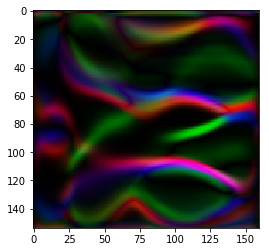

In [89]:
pyplot.imshow(np.abs(test_image[0][6:,:,:]-test_image[0][:-6,:,:]))

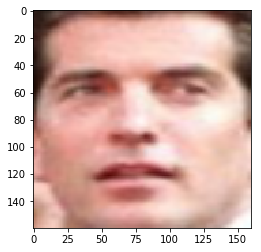

In [177]:
pyplot.imshow(pictures[40])

In [ ]:
decoding_model.save('decode_model_trained.h5')

In [ ]:
# get the face embedding for one face
def img_to_embedding(face_pixels, FRmodel):
    # print('start')
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    # print('starting prediction')
    yhat = FRmodel.predict(samples)
    # print('done with prediction')
    return yhat[0]